# CNN Using Keras and MADlib

E2E classification example using MADlib calling a Keras CNN.  Based on model architecture in https://keras.io/examples/cifar10_cnn/

To load images into tables we use the script called <em>madlib_image_loader.py</em> located at https://github.com/apache/madlib-site/tree/asf-site/community-artifacts/Deep-learning which uses the Python Imaging Library so supports multiple formats
http://www.pythonware.com/products/pil/


## Table of contents
<a href="#import_libraries">1. Import libraries</a>

<a href="#load_and_prepare_data">2. Load dataset into table</a>

<a href="#image_preproc">3. Call image preprocessor</a>

<a href="#define_and_load_model">4. Define and load model architecture</a>

<a href="#train">5. Train</a>

<a href="#plot">6. Plots by iteration and time</a>

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

https://www.cs.toronto.edu/~kriz/cifar.html

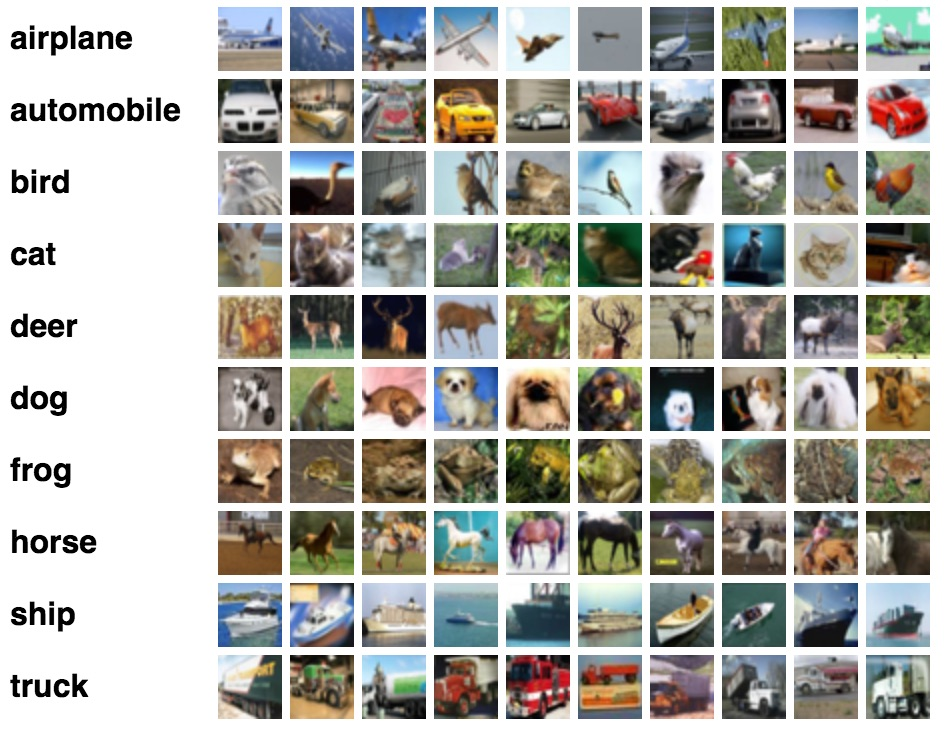

In [1]:
from IPython.display import Image
Image("../../images/cifar10.jpg")

In [1]:
%load_ext sql

In [2]:
# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.18.0-dev, git revision: rel/v1.17.0-89-g9d9f756, cmake configuration time: Thu Mar 4 23:11:53 UTC 2021, build type: release, build system: Linux-3.10.0-1160.11.1.el7.x86_64, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5"


<a id="import_libraries"></a>
# 1.  Import libraries
From https://keras.io/examples/mnist_transfer_cnn/ import libraries and define some params

In [5]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 100

Others needed in this workbook

In [6]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

<a id="load_and_prepare_data"></a>
# 2.  Set up image loader and load dataset into table

First set up image loader using the script called <em>madlib_image_loader.py</em> located at https://github.com/apache/madlib-site/tree/asf-site/community-artifacts/Deep-learning

In [11]:
madlib_site_dir = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data'
sys.path.append(madlib_site_dir)

# Import image loader module
from madlib_image_loader import ImageLoader, DbCredentials

# Specify database credentials, for connecting to db
db_creds = DbCredentials(user='fmcquillan',
                         host='localhost',
                         port='5432',
                         password='')

# Specify database credentials, for connecting to db
#db_creds = DbCredentials(user='gpadmin', 
#                         db_name='madlib',
#                         host='35.239.240.26',
#                         port='5432',
#                         password='')

# Initialize ImageLoader (increase num_workers to run faster)
iloader = ImageLoader(num_workers=5, db_creds=db_creds)

First load CIFAR-10 data from Keras consisting of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

In [12]:
# Load dataset into np array
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

%sql DROP TABLE IF EXISTS cifar_10_train_data, cifar_10_test_data;

# Save images to temporary directories and load into database
iloader.load_dataset_from_np(x_train, y_train, 'cifar_10_train_data', append=False)
iloader.load_dataset_from_np(x_test, y_test, 'cifar_10_test_data', append=False)

Done.
MainProcess: Connected to madlib db.
Executing: CREATE TABLE cifar_10_train_data (id SERIAL, x REAL[], y TEXT)
CREATE TABLE
Created table cifar_10_train_data in madlib db
Spawning 5 workers...
Initializing PoolWorker-1 [pid 66874]
PoolWorker-1: Created temporary directory /tmp/madlib_rrRCbykUw0
Initializing PoolWorker-2 [pid 66875]
PoolWorker-2: Created temporary directory /tmp/madlib_w1bgWZpxCn
Initializing PoolWorker-3 [pid 66876]
PoolWorker-3: Created temporary directory /tmp/madlib_q2Xgd1TDVg
PoolWorker-1: Connected to madlib db.
Initializing PoolWorker-4 [pid 66877]
PoolWorker-2: Connected to madlib db.
PoolWorker-4: Created temporary directory /tmp/madlib_NJDD5nxkcT
Initializing PoolWorker-5 [pid 66879]
PoolWorker-3: Connected to madlib db.
PoolWorker-5: Created temporary directory /tmp/madlib_rQ5Tgpwhkw
PoolWorker-4: Connected to madlib db.
PoolWorker-5: Connected to madlib db.
PoolWorker-1: Wrote 1000 images to /tmp/madlib_rrRCbykUw0/cifar_10_train_data0000.tmp
PoolWorker

PoolWorker-2: Removed temporary directory /tmp/madlib_w1bgWZpxCn
PoolWorker-5: Removed temporary directory /tmp/madlib_rQ5Tgpwhkw
PoolWorker-1: Removed temporary directory /tmp/madlib_rrRCbykUw0
Done!  Loaded 50000 images in 24.2264728546s
5 workers terminated.
MainProcess: Connected to madlib db.
Executing: CREATE TABLE cifar_10_test_data (id SERIAL, x REAL[], y TEXT)
CREATE TABLE
Created table cifar_10_test_data in madlib db
Spawning 5 workers...
Initializing PoolWorker-6 [pid 66886]
PoolWorker-6: Created temporary directory /tmp/madlib_us7NnIzs4Z
Initializing PoolWorker-7 [pid 66887]
PoolWorker-7: Created temporary directory /tmp/madlib_YhsJADC7Iq
Initializing PoolWorker-8 [pid 66888]
PoolWorker-8: Created temporary directory /tmp/madlib_izbrkdZU7f
PoolWorker-6: Connected to madlib db.
Initializing PoolWorker-9 [pid 66889]
PoolWorker-7: Connected to madlib db.
PoolWorker-9: Created temporary directory /tmp/madlib_GgLgXeKpOp
Initializing PoolWorker-10 [pid 66891]
PoolWorker-10: Creat

In [8]:
%sql select count(*) from cifar_10_train_data;

1 rows affected.


count
50000


<a id="image_preproc"></a>
# 3. Call image preprocessor

Transforms from one image per row to multiple images per row for batch optimization.  Also normalizes and one-hot encodes.

Training data

In [15]:
%%sql
DROP TABLE IF EXISTS cifar_10_train_data_packed, cifar_10_train_data_packed_summary;

SELECT madlib.training_preprocessor_dl('cifar_10_train_data',        -- Source table
                                       'cifar_10_train_data_packed', -- Output table
                                       'y',                          -- Dependent variable
                                       'x',                          -- Independent variable
                                        1000,                        -- Buffer size
                                        255                          -- Normalizing constant
                                        );

SELECT * FROM cifar_10_train_data_packed_summary;

Done.
1 rows affected.
1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
cifar_10_train_data,cifar_10_train_data_packed,y,x,text,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",1000,255.0,10,all_segments,all_segments


Test data

In [16]:
%%sql
DROP TABLE IF EXISTS cifar_10_test_data_packed, cifar_10_test_data_packed_summary;

SELECT madlib.validation_preprocessor_dl('cifar_10_test_data',          -- Source table
                                         'cifar_10_test_data_packed',   -- Output table
                                         'y',                           -- Dependent variable
                                         'x',                           -- Independent variable
                                         'cifar_10_train_data_packed',  -- Training preproc table
                                         1000                           -- Buffer size
                                        );

SELECT * FROM cifar_10_test_data_packed_summary;

Done.
1 rows affected.
1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
cifar_10_test_data,cifar_10_test_data_packed,y,x,text,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",1000,255.0,10,all_segments,all_segments


<a id="define_and_load_model"></a>
# 4. Define and load model architecture

Model architecture from https://keras.io/examples/cifar10_cnn/

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

Load into model architecture table using psycopg2

In [18]:
import psycopg2 as p2
#conn = p2.connect('postgresql://gpadmin@35.239.240.26:5432/madlib')
#conn = p2.connect('postgresql://fmcquillan@localhost:5432/madlib')
conn = p2.connect('postgresql://gpadmin@localhost:8000/madlib')
cur = conn.cursor()

%sql DROP TABLE IF EXISTS model_arch_library;
query = "SELECT madlib.load_keras_model('model_arch_library', %s, NULL, %s)"
cur.execute(query,[model.to_json(), "CNN from Keras docs for CIFAR-10"])
conn.commit()

# check model loaded OK
%sql SELECT model_id, name FROM model_arch_library;

Done.
1 rows affected.


model_id,name
1,CNN from Keras docs for CIFAR-10


<a id="train"></a>
# 5.  Train

In [19]:
%%sql
DROP TABLE IF EXISTS cifar_10_model, cifar_10_model_summary;

SELECT madlib.madlib_keras_fit('cifar_10_train_data_packed',    -- source table
                               'cifar_10_model',                -- model output table
                               'model_arch_library',            -- model arch table
                                1,                              -- model arch id
                                $$ loss='categorical_crossentropy', optimizer='rmsprop(lr=0.0001, decay=1e-6)', metrics=['accuracy']$$,  -- compile_params
                                $$ batch_size=32, epochs=3 $$,  -- fit_params
                                3,                              -- num_iterations
                                FALSE,                          -- use GPUs
                                'cifar_10_test_data_packed',    -- validation dataset
                                2                               -- metrics compute frequency
                              );

Done.
1 rows affected.


madlib_keras_fit
""


View the model summary:

In [20]:
%%sql
SELECT * FROM cifar_10_model_summary;

1 rows affected.


source_table,model,dependent_varname,independent_varname,model_arch_table,model_id,compile_params,fit_params,num_iterations,validation_table,metrics_compute_frequency,name,description,model_type,model_size,start_training_time,end_training_time,metrics_elapsed_time,madlib_version,num_classes,class_values,dependent_vartype,normalizing_const,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters
cifar_10_train_data_packed,cifar_10_model,y,x,model_arch_library,1,"loss='categorical_crossentropy', optimizer='rmsprop(lr=0.0001, decay=1e-6)', metrics=['accuracy']","batch_size=32, epochs=3",3,cifar_10_test_data_packed,2,None,None,madlib_keras,4886.20019531,2019-12-18 21:46:34.610075,2019-12-18 22:01:06.754356,"[568.416245222092, 872.144206047058]",1.17-dev,10,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",text,255.0,[u'accuracy'],0.612959980965,1.09410715103,"[0.563260018825531, 0.612959980964661]","[1.22403216362, 1.09410715103149]",0.597299993038,1.12304246426,"[0.55460000038147, 0.597299993038177]","[1.23818647861481, 1.12304246425629]","[2, 3]"


Evaluate using test data (same values as last iteration from the fit output summary above).

In [21]:
%%sql
DROP TABLE IF EXISTS cifar10_validate;

SELECT madlib.madlib_keras_evaluate('cifar_10_model',               -- model
                                    'cifar_10_test_data_packed',   -- test table
                                    'cifar10_validate'             -- output table
                                    );

SELECT * FROM cifar10_validate;

Done.
1 rows affected.
1 rows affected.


loss,metric,metrics_type
1.12304246426,0.597299993038,[u'accuracy']


<a id="plot"></a>
# 6.  Plots by iteration and by time
Accuracy by iteration

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


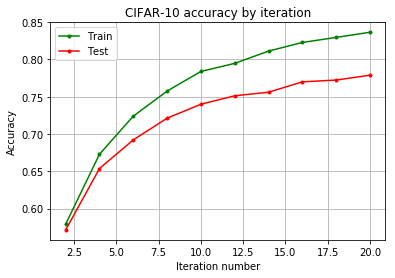

In [100]:
# get accuracy and iteration number
iters_proxy = %sql SELECT metrics_iters FROM cifar_10_model_summary;
train_accuracy_proxy = %sql SELECT training_metrics FROM cifar_10_model_summary;
test_accuracy_proxy = %sql SELECT validation_metrics FROM cifar_10_model_summary;

# get number of points
num_points_proxy = %sql SELECT array_length(metrics_iters,1) FROM cifar_10_model_summary;
num_points = num_points_proxy[0]

# reshape to np arrays
iters = np.array(iters_proxy).reshape(num_points)
train_accuracy = np.array(train_accuracy_proxy).reshape(num_points)
test_accuracy = np.array(test_accuracy_proxy).reshape(num_points)

#plot
plt.title('CIFAR-10 accuracy by iteration')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(iters, train_accuracy, 'g.-', label='Train')
plt.plot(iters, test_accuracy, 'r.-', label='Test')
plt.legend()

Loss by iteration

1 rows affected.
1 rows affected.


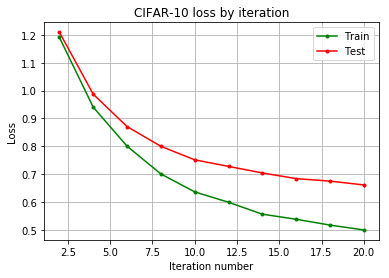

In [101]:
# get loss
train_loss_proxy = %sql SELECT training_loss FROM cifar_10_model_summary;
test_loss_proxy = %sql SELECT validation_loss FROM cifar_10_model_summary;

# reshape to np arrays
train_loss = np.array(train_loss_proxy).reshape(num_points)
test_loss = np.array(test_loss_proxy).reshape(num_points)

#plot
plt.title('CIFAR-10 loss by iteration')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(iters, train_loss, 'g.-', label='Train')
plt.plot(iters, test_loss, 'r.-', label='Test')
plt.legend()

Accuracy by time

1 rows affected.


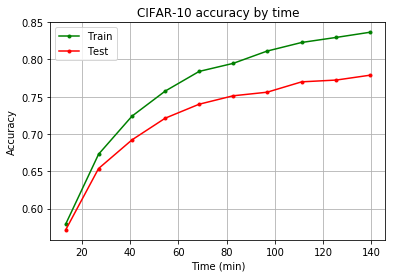

In [108]:
# get time
time_proxy = %sql SELECT metrics_elapsed_time FROM cifar_10_model_summary;

# reshape to np arrays
time = np.array(time_proxy).reshape(num_points)/60.0

#plot
plt.title('CIFAR-10 accuracy by time')
plt.xlabel('Time (min)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(time, train_accuracy, 'g.-', label='Train')
plt.plot(time, test_accuracy, 'r.-', label='Test')
plt.legend()

Time to achieve a given accuracy

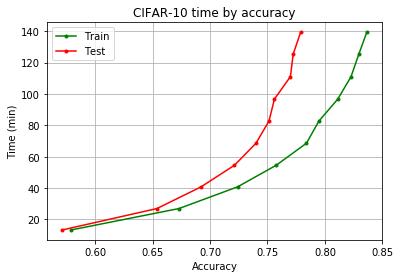

In [109]:
#plot
plt.title('CIFAR-10 time by accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Time (min)')
plt.grid(True)
plt.plot(train_accuracy, time, 'g.-', label='Train')
plt.plot(test_accuracy, time, 'r.-', label='Test')
plt.legend()